# Exciton wave functions in massive Dirac model

## References
[1] M. Van der Donck, M. Zarenia, and F. M. Peeters, Phys. Rev. B 96, 035131 (2017).

In [622]:
import numpy as np
from scipy.sparse import *
import scipy.sparse.linalg as splinalg
import scipy.linalg as linalg
from scipy.special import struve
from scipy.special import y0
from scipy.special import j0
from scipy.special import j1
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix
from scipy.integrate import quad
from scipy.interpolate import interp2d
%matplotlib inline

In [679]:
### Constants and parameters of the model
e0=1.6e-19 # Coulomb
eps0=8.854e-12 # F/m
kappa=1.
a0=3.193 # lattice constant for MoS2 from Ref.[1], in Angstrom 
r0=41.47/a0 # screening length for MoS2 from Ref.[1], in normalized units
lam=0.15/2. # in eV for MoS2 from Ref.[1]
Delta=1.66 # in eV for MoS2 from Ref.[1]
thop=1.10 # hopping parameter t in eV
hbar=1.05e-34 # J s
m0=9.1e-31 # kg
meff=0.50*m0

In [680]:
### A-exciton
shth=1
sete=1

In [683]:
### My definitions, in units of thop
Dh=(Delta-shth*lam)/thop; 
De=(Delta-sete*lam)/thop; 
Lambda=lam*(sete-shth)/thop;
Vunit=e0/(4.*np.pi*kappa*eps0*a0*1.e-10)/thop

In [690]:
### Keldysh potential in normalized units
# Input:
#    r: radial coordinate in units of a0
#    r0: screening length in units of a0
# Output:
#    Potential in units of thop
def VKeldysh(r,r0): 
    return Vunit*(struve(0,r/r0)-y0(r/r0))*np.pi/(2.*r0) # in eV

rcut=1. # cutting distance in units of a0
def V(r):
    return np.minimum(VKeldysh(np.ones_like(r)*rcut,r0),VKeldysh(r,r0))

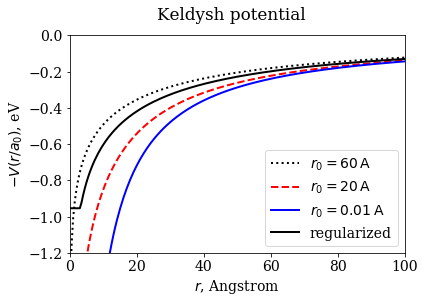

In [704]:
### Keldysh potential check: coincides with Fig.1 of Van der Donck et al.
plt.rc('font', size=14)
fig,ax = plt.subplots()
plt.suptitle('Keldysh potential')
ax.set_xlim([0,100])
ax.set_ylim([-1.2,0.])
ax.set_xlabel(r'$r$, Angstrom')
ax.set_ylabel(r'$-V(r/a_0)$, eV')
rinA = np.linspace(0.001,100,200) # in A
ax.plot(rinA,-thop*VKeldysh(rinA/a0,60./a0),'k',ls='dotted',lw=2,label=r'$r_0=60\rm\,A$')
ax.plot(rinA,-thop*VKeldysh(rinA/a0,20./a0),'r',ls='dashed',lw=2,label=r'$r_0=20\rm\,A$')
ax.plot(rinA,-thop*VKeldysh(rinA/a0,0.01/a0),'b',ls='solid',lw=2,label=r'$r_0=0.01\rm\,A$')
ax.plot(rinA,-thop*V(rinA/a0),'k',ls='solid',lw=2,label='regularized')
ax.legend();

In [705]:
kmax=0.1; dk=0.002; M=int(kmax/dk); M

50

In [714]:
krange0=np.linspace(dk,kmax,10)

In [740]:
def k(n):
    return dk*n+dk

def V0integrand(r,k1,k2):
    return V(r)*j0(k1*r)*j0(k2*r)*r

@np.vectorize
def V0(k1,k2):
    return quad(V0integrand,0.,2000,args=(k1,k2),limit=200)[0]

def V1integrand(r,k1,k2):
    return V(r)*j1(k1*r)*j1(k2*r)*r

@np.vectorize
def V1(k1,k2):
    return quad(V1integrand,0.,2000,args=(k1,k2),limit=200)[0]

(0, 1000)

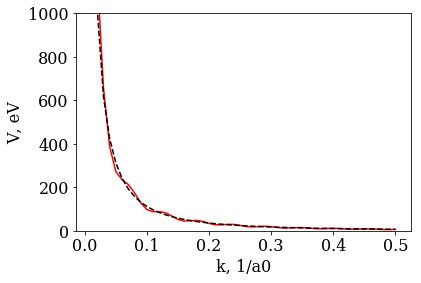

In [761]:
### Check: comparison to Keldysh potential in momentum space
def VKeldysh_momspace(k):
    return Vunit*2.*np.pi/(k*(1.+r0*k))
ktest=np.linspace(0.01,0.5,50)
fig,ax=plt.subplots()
ax.set_xlabel('k, 1/a0')
ax.set_ylabel('V, eV')
plt.plot(ktest,2.*np.pi*V0(0.0,ktest),'r')
plt.plot(ktest,VKeldysh_momspace(ktest),'k',ls='dashed');
ax.set_ylim([0,1000])

In [743]:
kk1,kk2 = np.meshgrid(krange0,krange0,indexing='xy')

In [744]:
%time V0data=V0(kk1,kk2)

CPU times: user 2.81 s, sys: 0 ns, total: 2.81 s
Wall time: 2.81 s


In [745]:
%time V1data=V1(kk1,kk2)

CPU times: user 2.32 s, sys: 0 ns, total: 2.32 s
Wall time: 2.31 s


In [746]:
interp_kind='linear'
V0interp=interp2d(krange0, krange0, V0data, kind=interp_kind)
V1interp=interp2d(krange0, krange0, V1data, kind=interp_kind)

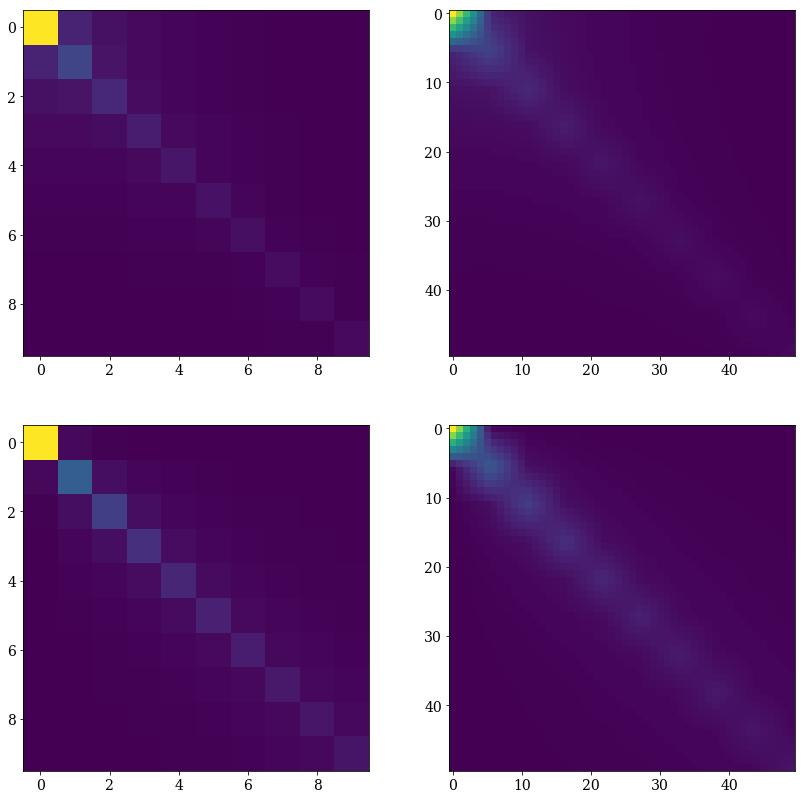

In [747]:
krange=k(np.arange(M))
V0interp_data=V0interp(krange,krange)
V1interp_data=V1interp(krange,krange)
fig,ax=plt.subplots(2,2,figsize=(14,14))
#kkk1,kkk2 = np.meshgrid(krange,krange,indexing='xy')
#ax[0,0].contour(kk1, kk2, V0data)
ax[0,0].imshow(V0data)
#ax[0,1].contour(kkk1, kkk2, V0interp_data)
ax[0,1].imshow(V0interp_data)
#ax[1,0].contour(kk1, kk2, V1data)
ax[1,0].imshow(V1data)
#ax[1,1].contour(kkk1, kkk2, V1interp_data)
ax[1,1].imshow(V1interp_data)

In [748]:
data=[]
offsets=[]
for m in range(M):
    diagm=np.array([np.array([-dk*k(n+m)*V1interp(k(n),k(n+m)),
                              Dh-dk*k(n+m)*V0interp(k(n),k(n+m)),
                              -De-dk*k(n+m)*V0interp(k(n),k(n+m)),
                              -dk*k(n+m)*V1interp(k(n),k(n+m))]) for n in range(M)]).ravel()
    data.append(diagm)
    offsets.append(-4*m)

In [749]:
sdiag0=np.array([[-1j*k(n),0.,1j*k(n),0.] for n in range(M)]).ravel()
data.append(sdiag0)
offsets.append(-1)

In [750]:
ssdiag0=np.array([[-1j*k(n),1j*k(n),0.,0.] for n in range(M)]).ravel()
data.append(ssdiag0)
offsets.append(-2)

In [751]:
np.set_printoptions(precision=6)
matrix=dia_matrix((data, offsets), shape=(4*M, 4*M)).toarray().real

In [752]:
%time evalsunsorted,Tevecs=linalg.eigh(matrix)
evecsunsorted=Tevecs.T
#inds=np.argsort(evalsunsorted**2)
inds=np.argsort(evalsunsorted)
evals=evalsunsorted[inds]
evecs=evecsunsorted[inds]
evals[:10]

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 20 ms


array([-7.237099e+01, -1.714768e-01, -1.714768e-01, -9.897102e-02,
       -9.896988e-02, -9.069352e-02, -9.069352e-02, -6.792537e-02,
       -6.792168e-02, -6.385157e-02])

In [753]:
def psi1(r,nv):
    return np.sum(evecs[nv,0::4][:,None]*j1(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def psi2(r,nv):
    return np.sum(evecs[nv,1::4][:,None]*j0(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def psi3(r,nv):
    return np.sum(evecs[nv,2::4][:,None]*j0(krange[:,None]*r)*krange[:,None]*dk,axis=0)

def psi4(r,nv):
    return np.sum(evecs[nv,3::4][:,None]*j1(krange[:,None]*r)*krange[:,None]*dk,axis=0)

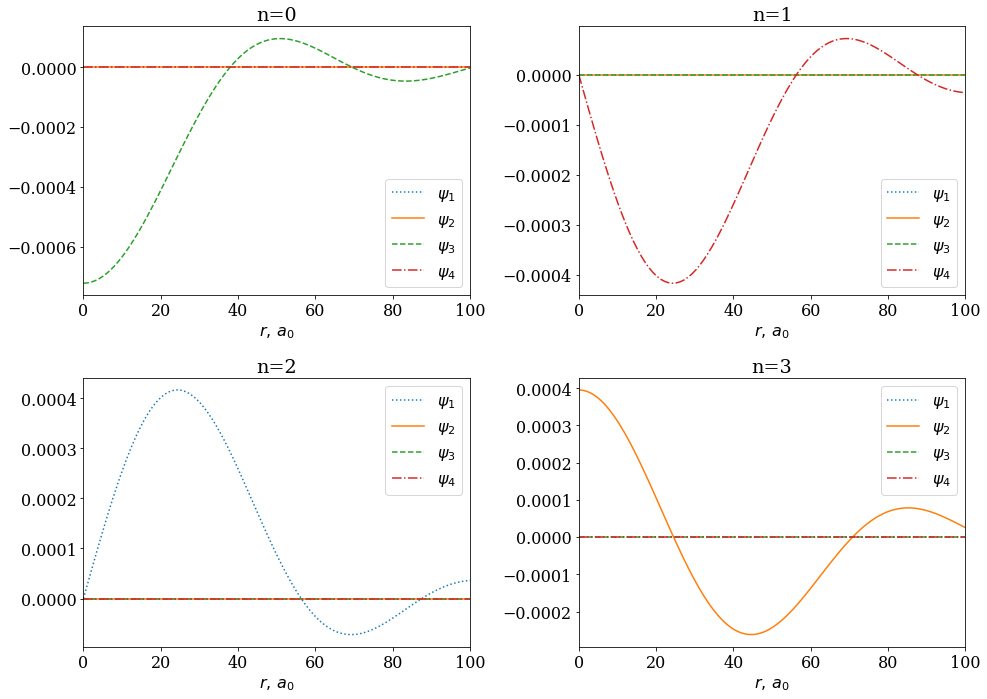

In [756]:
plt.rc('font', size=16)
fig,ax=plt.subplots(2,2,figsize=(14,10))
rmax=100.; lw=1.5; alpha=1;
rrange=np.linspace(0.,rmax,100)

for (i,nv) in [[(0,0),0],[(0,1),1],[(1,0),2],[(1,1),3]]:
    ax[i].plot(rrange,psi1(rrange,nv),ls='dotted',label=r'$\psi_1$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,psi2(rrange,nv),ls='solid',label=r'$\psi_2$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,psi3(rrange,nv),ls='dashed',label=r'$\psi_3$',lw=lw,alpha=alpha)
    ax[i].plot(rrange,psi4(rrange,nv),ls='dashdot',label=r'$\psi_4$',lw=lw,alpha=alpha)
    ax[i].set_xlim([0.,rmax])
    ax[i].set_xlabel(r'$r,\,a_0$')
    ax[i].set_title('n='+str(nv))
    ax[i].legend()
plt.tight_layout()